# Trophic model for the gut microbiome
The human gut microbial community is complex because of 3 reasons: (1) many microbial species ($\approx$ 570); (2) many metabolites involved ($\approx$ 244); and (3) many microbe-metabolite interactions/links (>4400). Of all types of microbe-metabolite interactions/links, the cross-feeding makes the system more complicated to interpret. Previously, a literature-curated interspecies network of the human gut microbiota, called [NJS16](https://www.nature.com/articles/ncomms15393) is reported. This is an extensive data resource composed of ∼570 microbial species and 3 human cell types metabolically interacting through >4,400 small-molecule transport and macromolecule degradation events.

Here, we devoted to building a Consumer-Resource model (CRM) with trophic levels posted in the paper "[an evidence for a multi-level trophic organization of the human gut microbiome](https://www.biorxiv.org/content/10.1101/603365v1.full-text)". The model is devoted to studying the complex microbe-metabolite network in human guts.

In concise, a trophic level is considered as one round of carbon processing and is composed of two processes: resource allocation to microbes and the following resource/byproduct generation by microbes. The simulation is stopped after several trophic levels because the residence time of resources in the human gut is assumed to be finite.

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem

#%% Plot Tong's default setting
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims

In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("data.pickle","rb")
metagenome_ID, metagenome, metabolome_ID, metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.reindex(net['metabolites_ID'].values).values.flatten()
ingoingNodesTemp = df_microbes.reindex(net['microbes_ID'].values).values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()
net_temp = net.copy()
net['edgeType'][net['edgeType']==5] = 2
net_temp['edgeType'][net_temp['edgeType']==5] = 3
net = net.append(net_temp).drop_duplicates()
net_ori = net.copy()

metagenome_ID_reduced = df_microbes.reindex(metagenome_ID).values.flatten()
metagenome_ID = metagenome_ID_reduced[~np.isnan(metagenome_ID_reduced)].astype(int)

metabolome_ID_reduced = df_metabolites.reindex(metabolome_ID).values.flatten()
metabolome_ID = metabolome_ID_reduced[~np.isnan(metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.reindex(i_selfish).values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)



In [4]:
len(net_ori)

1075

## Run the simulation with reduced matrix forms for one individual

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.1508132751163695
            Iterations: 16
            Function evaluations: 354
            Gradient evaluations: 16
     fun: 3.1508132751163695
     jac: array([ 0.        ,  0.00985718,  0.00507498,  0.00553903,  0.06272525,
        0.01278242,  0.03304648,  0.00766438, -0.00600925,  0.01459837,
        0.00206962,  0.01478863,  0.12712204,  0.08330923, -0.00155348,
        0.01078975,  0.08886299,  0.02255559, -0.01123697,  0.0137887 ])
 message: 'Optimization terminated successfully.'
    nfev: 354
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([5.00000000e-02, 1.10193902e-01, 4.62982404e+00, 3.86161131e-01,
       0.00000000e+00, 0.00000000e+00, 7.23407723e-17, 7.21670605e-02,
       3.79355197e-02, 0.00000000e+00, 4.71539308e-01, 1.65347241e-02,
       4.53575248e-16, 0.00000000e+00, 3.52982479e-01, 2.22129889e-01,
       4.00798663e-16, 0.00000000e+00, 2.19499457

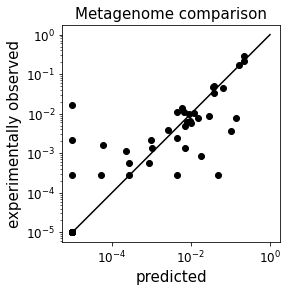

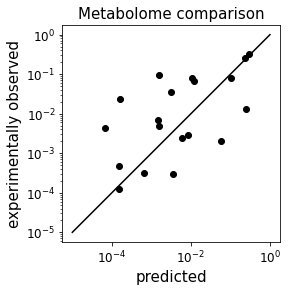

In [5]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net['edgeType']==2) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net['edgeType']==3) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 5; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[metagenome_ID] = metagenome.iloc[:,pa] / np.sum(metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[metabolome_ID.values] = metabolome.iloc[:,pa]
metabolome_measured[metabolome_ID] = metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))


## Run the simulation with reduced matrix forms for all individuals

In [6]:
corr_list = np.zeros((metabolome.shape[1],2))
diet_list = np.zeros((metabolome.shape[1], 20))
for pa in range(metabolome.shape[1]):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[metagenome_ID] = metagenome.iloc[:,pa] / np.sum(metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[metabolome_ID] = metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
    if i_common.shape[0] >= 2:
        corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    else:
        corr_list[pa, 0] = -1
        corr_list[pa, 1] = -1
    
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(corr_list[pa, 0])
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(corr_list[pa, 1])

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.42648524764264306
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.6529538156648987
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.9011443045068158
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.5125407257525838
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.8058052750461028
(Correla

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.8927271064735675
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.7756813394383089
24
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.9693577910663201
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.5352094114565162
25
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.40508834835387947
(Correla

In [7]:
print("The mean Pearson correlation coefficient is", np.mean(corr_list[:,1]))


The mean Pearson correlation coefficient is 0.6108124371444302


In [8]:
MAX_ID_microbes

72

### Decompose the total microbial biomass to different layers

In [9]:
#def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
def m2b_multiple_levels_decomposition(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_layer = np.zeros((MAX_ID_microbes, MAX_ID_metabolites, numLevels_max));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);
        m2b_layer[:,:,ii] = np.matmul((1 - f_mul) * m2b.T, s_step_ii[:,:]) # m2b_layer[:,:,ii] has an extra multiplication of m2b and (1-f).
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2b_layer, m2m_total, m2m_layer]


In [10]:
biomass_at_each_layer_all = np.zeros((metabolome.shape[1], numLevels_max, MAX_ID_microbes)); 
corr_list = np.zeros((metabolome.shape[1],2))
diet_list = np.zeros((metabolome.shape[1], 20))
for pa in range(metabolome.shape[1]):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[metagenome_ID] = metagenome.iloc[:,pa] / np.sum(metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2b_layer, m2m_total, m2m_layer = m2b_multiple_levels_decomposition(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[metabolome_ID] = metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
    if i_common.shape[0] >= 2:
        corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    else:
        corr_list[pa, 0] = -1
        corr_list[pa, 1] = -1
    
    diet_list[pa, :] = res.x
    
    biomass_at_each_layer = np.zeros((numLevels_max, MAX_ID_microbes)); 
    for ii in range(numLevels_max):
        biomass_at_each_layer[ii,:] = np.dot(m2b_layer[:,:,ii], x_full)[:]
    biomass_at_each_layer_all[pa,:,:] = biomass_at_each_layer[:,:]
    
    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(corr_list[pa, 0])
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(corr_list[pa, 1])

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.42648524764264306
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.6529538156648987
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.9011443045068158
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.5125407257525838
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.8058052750461028
(Correla

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.9693577910663201
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.5352094114565162
25
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.40508834835387947
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
0.38129947051772767
26
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
0.9698716344281271
(Correl

<ipython-input-11-dd5ef362f6ad>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


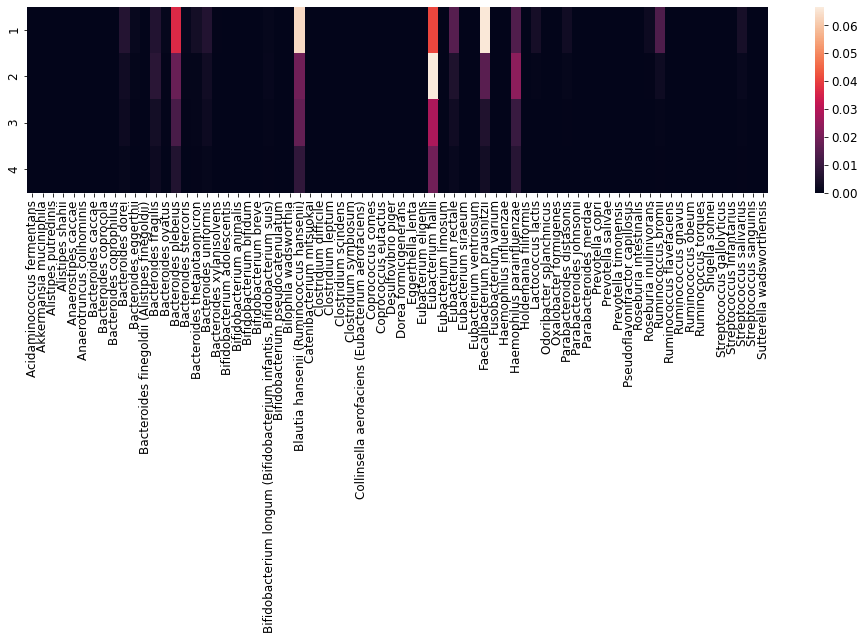

In [11]:
#fig, ax = plt.subplots(1,1, figsize=[200,500])
fig_dims = figure_size_setting(500)
fig_dims = [fig_dims[0]*3, fig_dims[1]*1]
fig, ax = plt.subplots(1, 1, figsize=fig_dims, sharex=True)

sns.heatmap(biomass_at_each_layer_all[5,:,:], yticklabels = np.arange(1,5,1), 
            xticklabels=names.loc[df_microbes.index].values.flatten(), ax=ax)

fig.tight_layout()
#fig.savefig("./figures/XXX.png", dpi=300)

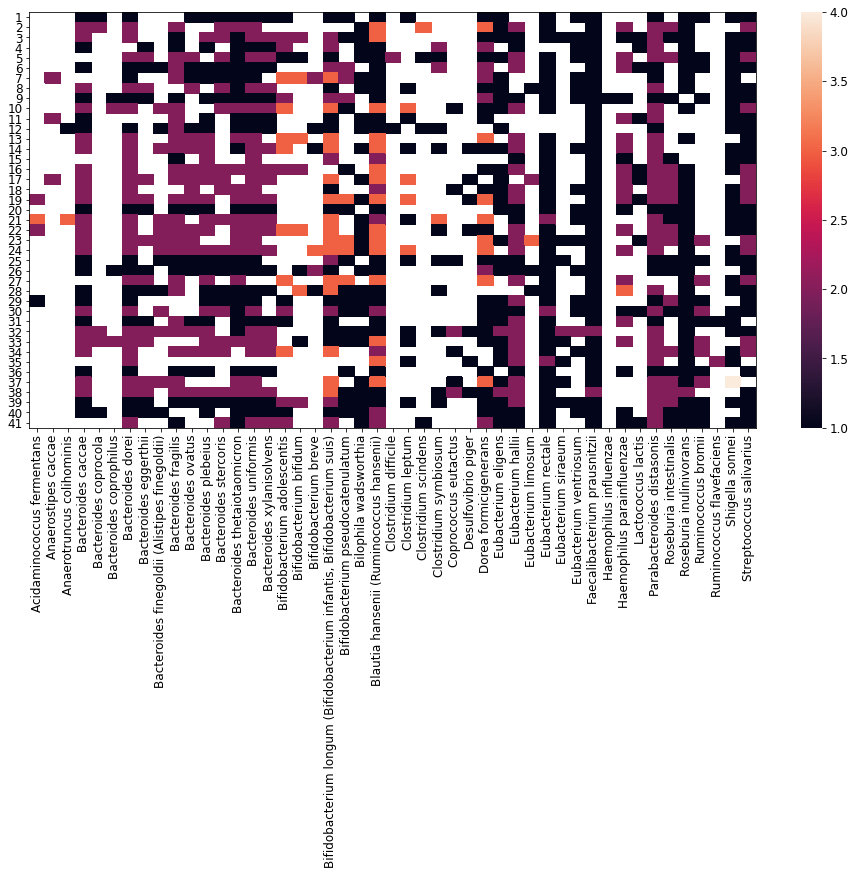

In [12]:
assigned_layers = np.ones((metabolome.shape[1], MAX_ID_microbes)) * (-1) #### give invalid ranks initially
for pa in range(metabolome.shape[1]):
    biomass_at_each_layer = biomass_at_each_layer_all[pa,:,:]
    i_nonzero_microbes = np.where(np.sum(biomass_at_each_layer, 0) > 0)[0]
    assigned_layers[pa, i_nonzero_microbes] = np.argmax(biomass_at_each_layer, 0)[i_nonzero_microbes]+1
assigned_layers[assigned_layers<0] = np.nan

#fig, ax = plt.subplots(1,1, figsize=[200,500])
fig_dims = figure_size_setting(1200)
fig_dims = [fig_dims[0]*1.0, fig_dims[1]*1.5]
fig, ax = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
i_microbes_with_layers = np.where(np.nansum(assigned_layers, 0))[0]
sns.heatmap(assigned_layers[:,i_microbes_with_layers], yticklabels = np.arange(1,metabolome.shape[1]+1,1), 
            xticklabels=names.loc[df_microbes.index[i_microbes_with_layers]].values.flatten(), ax=ax)
plt.yticks(rotation=0) 
for _, spine in ax.spines.items():
    spine.set_visible(True)
fig.tight_layout()
#fig.savefig("./figures/XXX.png", dpi=300)


<ipython-input-14-910c193c9803>:6: RuntimeWarning: invalid value encountered in true_divide
  average_layers = np.sum((biomass_at_each_layer / np.sum(biomass_at_each_layer,0)) * np.matlib.repmat(np.arange(1,5,1).reshape(4,1), 1, biomass_at_each_layer.shape[1]), 0)


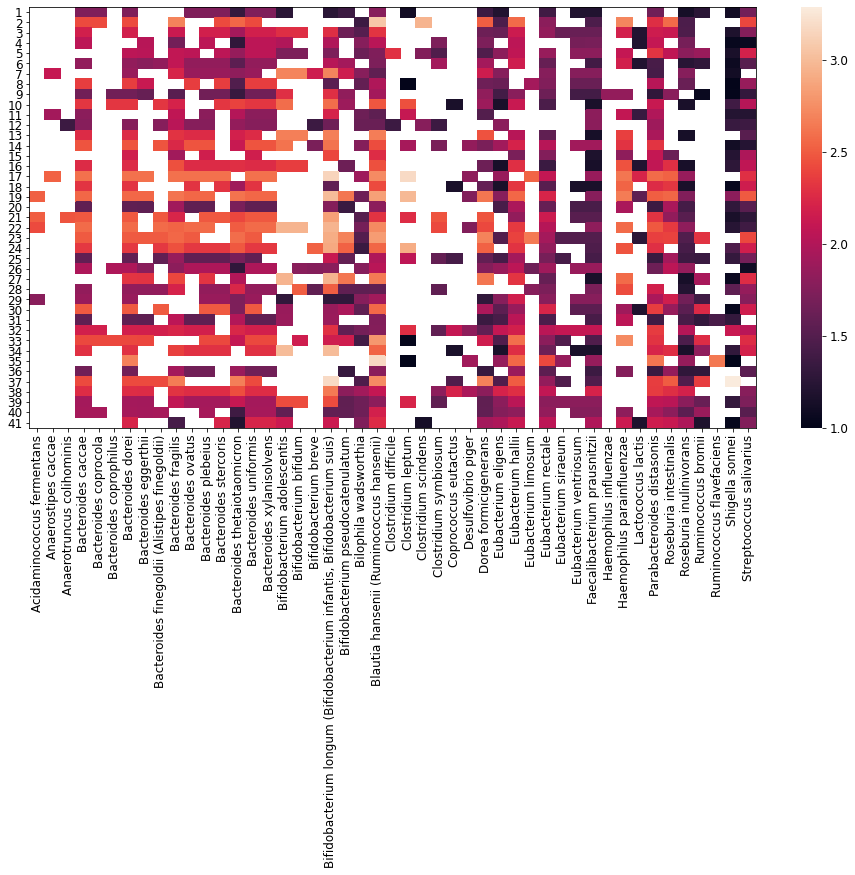

In [14]:
assigned_layers = np.ones((metabolome.shape[1], MAX_ID_microbes)) * (-1) #### give invalid ranks initially
for pa in range(metabolome.shape[1]):
    biomass_at_each_layer = biomass_at_each_layer_all[pa,:,:]
    i_nonzero_microbes = np.where(np.sum(biomass_at_each_layer, 0) > 0)[0]
    #assigned_layers[pa, i_nonzero_microbes] = np.argmax(biomass_at_each_layer, 0)[i_nonzero_microbes]+1
    average_layers = np.sum((biomass_at_each_layer / np.sum(biomass_at_each_layer,0)) * np.matlib.repmat(np.arange(1,5,1).reshape(4,1), 1, biomass_at_each_layer.shape[1]), 0)
    assigned_layers[pa, i_nonzero_microbes] = average_layers[i_nonzero_microbes]
assigned_layers[assigned_layers<0] = np.nan

#fig, ax = plt.subplots(1,1, figsize=[200,500])
fig_dims = figure_size_setting(1200)
fig_dims = [fig_dims[0]*1, fig_dims[1]*1.5]
fig, ax = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
i_microbes_with_layers = np.where(np.nansum(assigned_layers, 0))[0]
sns.heatmap(assigned_layers[:,i_microbes_with_layers], yticklabels = np.arange(1,metabolome.shape[1]+1,1), 
            xticklabels=names.loc[df_microbes.index[i_microbes_with_layers]].values.flatten(), ax=ax)
plt.yticks(rotation=0) 
for _, spine in ax.spines.items():
    spine.set_visible(True)
fig.tight_layout()
#fig.savefig("./figures/XXX.png", dpi=300)


In [15]:
i_microbes_with_layers = np.where(np.nansum(assigned_layers, 0))[0]
df_assigned_layers = pd.DataFrame(data=assigned_layers[:,i_microbes_with_layers],    # values
                      columns=names.loc[df_microbes.index[i_microbes_with_layers]].values.flatten())  # 1st row as the column names
df_assigned_layers.to_csv("./assigned_layers_Thai.csv")


In [14]:
'''
#biomass_at_each_layer_all.to_csv("./biomass_at_each_layer_all_Thai_data.csv")
########### pickle all processed data which are useful for simulations
import pickle
pickle_out = open("./biomass_at_each_layer_all.pickle","wb")
pickle.dump([biomass_at_each_layer_all], pickle_out)
pickle_out.close()
'''

'''
########### import the pickled file
import pickle
pickle_in = open("./biomass_at_each_layer_all_Thai_data.pickle","rb")
[biomass_at_each_layer_all] = pickle.load(pickle_in)
'''


'\n########### import the pickled file\nimport pickle\npickle_in = open("./biomass_at_each_layer_all.pickle","rb")\n[biomass_at_each_layer_all] = pickle.load(pickle_in)\n'

In [19]:
names.loc[df_metabolites.index].iloc[i_intake]

,Names
oldID,
2044,"Cellotetraose (Cellohexaose, Cellopentaose, Ce..."
2060,"D-Arabinose (L-Arabinose, Arabinose, L-Arabino..."
2061,D-Fructose (Fructose)
2064,D-Galactose
2065,D-Galacturonate
2068,D-Glucose (Glucose)
2069,D-Glucuronic acid (D-Glucuronate)
2072,D-Mannose (Mannose)
2074,D-Ribose (Ribose)


In [20]:
names.apply(lambda x: "Lactate" in str(x), axis=1).sum()

1

In [21]:
names[names.apply(lambda x: "Lactate" in str(x), axis=1)]

,Names
IDs,
2141,"L-Lactate ([S]-Lactate, Lactate, D-Lactate, [R..."
